# Computing SFRD

In the present work, we want to update the measurements of star formation rate density from the recent observations. The idea is to use luminosity function (the Schechter function) with the updated parameters from the literature to compute the luminosity density and then using this updated luminosity function to calculate the star formation rate density. In this notebook we try to summarize our work.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils as utl
import os

## The Schechter function

The Schechter function (Schechter 1975) is an analytic expression for the luminosity of galaxies which can be written as follows:

$$\phi(L) = \left( \frac{\phi^*}{L^*} \right) \left( \frac{L}{L^*} \right)^\alpha \exp{\left( -\frac{L}{L^*} \right)}$$

This function essentially describes the number of galaxies in the given range of luminosity $L$ to $L+dL$. It is evident from the above equation that it is a three parameter function with parameters $\phi^*$, $L^*$ and $\alpha$. Here, $\alpha$ represents the power-law parameter for the faint-end and $L^*$ is the characteristic luminosity, while $\phi*$ serves as the normalisation constant.

Below we plot an example of the Schechter function for the parameters from Bouwens et al. (2021) paper; the parameters are $M_*=-20.28$, $\phi_*=4 \times 10^{-3}$, and $\alpha=-1.52$ --- these parameters are for the redshift $2.1$.

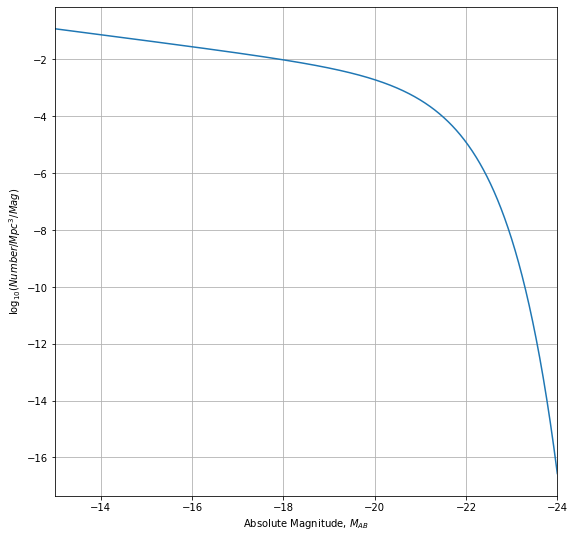

In [2]:
# Defining the Schechter function parameters
mst = -20.28
pst = 4e-3
alp = -1.52

# Range of Magnitudes
mags = np.linspace(-24, -13, 1000)

# The Schechter function
nos = utl.schechter_mag(M=mags, phi1=pst, alpha=alp, m1=mst)
log_nos = np.log10(nos)

# Plotting
plt.figure(figsize=(9,9))
plt.plot(mags, log_nos)
plt.xlabel(r'Absolute Magnitude, $M_{AB}$')
plt.ylabel(r'$\log_{10} (Number/Mpc^3/Mag)$')
plt.xlim([np.max(mags), np.min(mags)])
plt.grid()

In above figure, we can see the nature of the Schechter function. It is evident that, at the fainter magnitudes, the function has the power law shape with the power law index $\alpha$ (this transition happens below the characteristic magnitude $M_*$). Further, we can see that, the more steeper the slope of the faint end, more the contribution from the faint end to the luminosity density. We also note here that, the Schechter function is generally use to find the luminosity function at shorter wavelengths. At higher wavelengths, some other various types of functions have been defined in various papers. One such function, used in Takeuchi et al. (2002) (defined first in Sandage, Tammann & Yahil 1979) is given by,

$$\phi(L) d\log{L} = \phi_* \left( \frac{L}{L_*} \right)^{1-\alpha} \exp{\left( -\frac{1}{2\sigma^2} \left\{ \log{\left[1 + \frac{L}{L_*} \right]}\right\}^2 \right)} d\log L$$

## The luminosity density

We can integrate the luminosity function over luminosity to find the luminosity density, meaning in the sense that the total luminosity coming oout of the given region. We use the `scipy` function `scipy.integrate.simps` function to perform the following integration:

$$\rho (> L_{min}) = \int_{L_{min}}^\infty L \phi(L) dL$$

Here, $L_{min}$ is the minimum luminosity at the faint end which we have taken as the lower end for the above integration. It is evident that the luminosity density will depend on the exact value of $L_{min}$. But for now, we take this value from the Madau & Dickinson (2014) paper, which is $0.03L_*$ ($L_*$ is the characteristic luminosity from the Schechter function).

## Star formation rate density

Once we computed the luminosity density, we can find the star formation rate density just by multiplying it with the proper conversion factor. Such factors are originally postulated in various publications, and later summarized in Madau & Dickinson (2014),

$$SFR = \kappa_{FUV}\times \rho_{FUV}$$ and $$SFR = \kappa_{IR} \times \rho_{IR}$$

where, different $\kappa$s are the abovementioned conversion factors and defined as,

$$\kappa_{FUV} = 2.2 \times 10^{-10} M_\odot year^{-1} L_\odot^{-1}$$ and $$\kappa_{IR} = 4.5 \times 10^{-44} M_\odot year^{-1} erg^{-1} s$$

Here, we note that the value of $\kappa_{FUV}$ is at $1500$ angstrom and it is in the units of solar luminosity, so we want to divide this value to the solar luminosity to find $\kappa_{FUV}$ in cgs units.

We computed the values of SFRD at various redshifts, and using the luminosity function parameters from different papers, elsewhere, and plot them below.

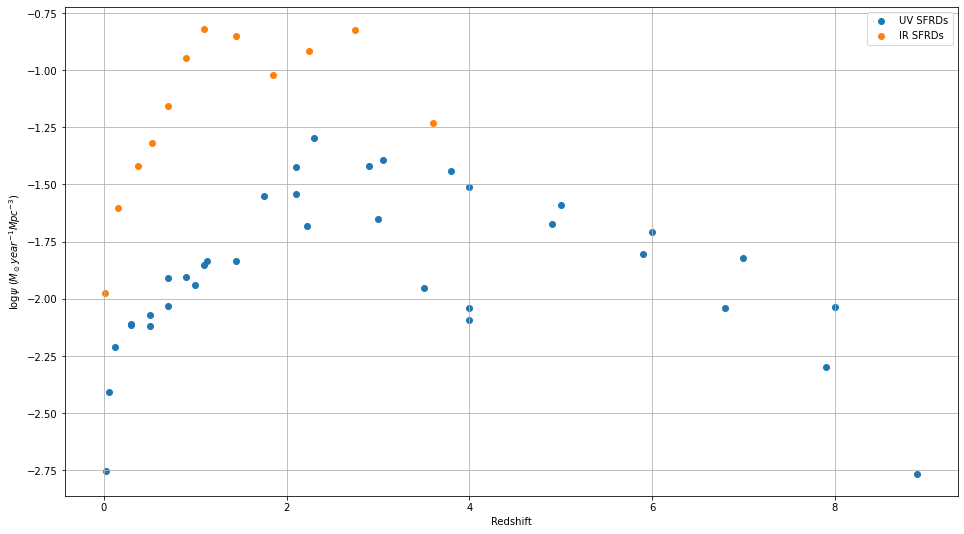

In [3]:
# For UV
ppr_uv = np.loadtxt('sfrd_all_wo_err_UV.dat', usecols=0, unpack=True, dtype=str)
zd_uv, zu_uv, sfrd_uv = np.loadtxt('sfrd_all_wo_err_UV.dat', usecols=(1,2,3), unpack=True)
zcen_uv = (zd_uv + zu_uv)/2
log_sfrd_uv = np.log10(sfrd_uv)

# For IR
ppr_ir = np.loadtxt('sfrd_all_wo_err_IR.dat', usecols=0, unpack=True, dtype=str)
zd_ir, zu_ir, sfrd_ir = np.loadtxt('sfrd_all_wo_err_IR.dat', usecols=(1,2,3), unpack=True)
zcen_ir = (zd_ir + zu_ir)/2
log_sfrd_ir = np.log10(sfrd_ir)

# Plotting them
plt.figure(figsize=(16, 9))
plt.scatter(zcen_uv, log_sfrd_uv, label='UV SFRDs')
plt.scatter(zcen_ir, log_sfrd_ir, label='IR SFRDs')
plt.xlabel('Redshift')
plt.ylabel(r'$\log{\psi}$ ($M_\odot year^{-1} Mpc^{-3}$)')
plt.grid()
plt.legend(loc='best')

Note that, they seems to follow an overall pattern. However, the scales of UV and IR SFRDs are not exactly same in order to follow this apprant pattern. Because of this, we want to correct for the dust in UV. Once we do that, we can fit a function to the global trend of SFRD. Such a function is defined in Madau & Dickinson (2014),

$$ \psi(z) = 0.015 \frac{(1+z)^{2.7}}{1 + [(1+z)/2.9]^{5.6}} M_\odot \ year^{-1} Mpc^{-3}$$

Here, the symbols have their usual meanings. Now, we define this function below and try to plot it after applying a dust correction to the UV SFRDs (again, we calculated dust corrected SFRDs in another notebook prior and use them directly here).

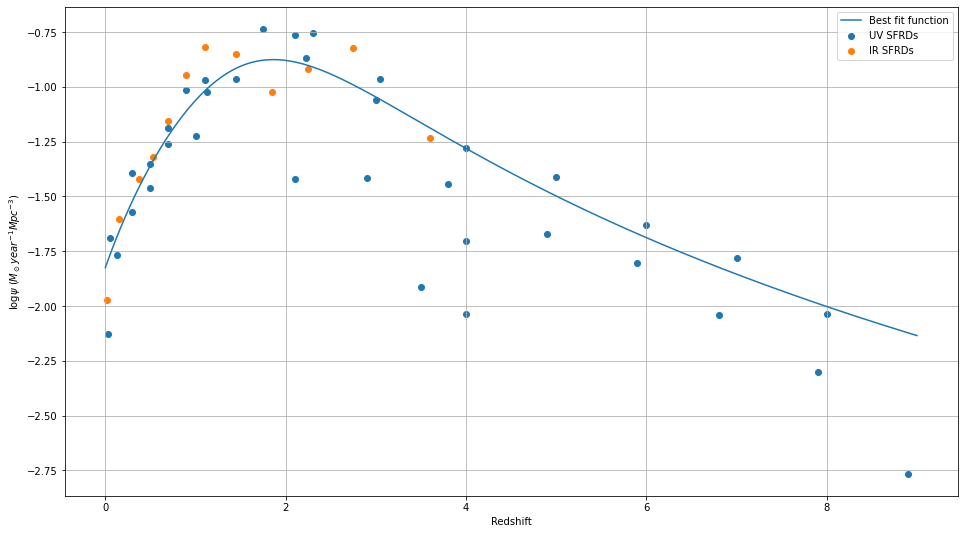

In [4]:
# Defining best-fitted SFRD

def psi_md(z):
    ab = (1+z)**2.7
    cd = ((1+z)/2.9)**5.6
    ef = 0.015*ab/(1+cd)
    return ef

# Calculating psi(z)
znew = np.linspace(0,9,1000)
psi1 = psi_md(znew)
psi2 = np.log10(psi1)

# Dust corrected UV SFRDs,
ppr_uvd = np.loadtxt('sfrd_all_wo_err_dust_UV.dat', usecols=0, unpack=True, dtype=str)
zd_uvd, zu_uvd, sfrd_uvd = np.loadtxt('sfrd_all_wo_err_dust_UV.dat', usecols=(1,2,3), unpack=True)
zcen_uvd = (zd_uvd + zu_uvd)/2
log_sfrd_uvd = np.log10(sfrd_uvd)

# Plotting them
plt.figure(figsize=(16, 9))
plt.scatter(zcen_uvd, log_sfrd_uvd, label='UV SFRDs')
plt.scatter(zcen_ir, log_sfrd_ir, label='IR SFRDs')
plt.plot(znew, psi2, label='Best fit function')
plt.xlabel('Redshift')
plt.ylabel(r'$\log{\psi}$ ($M_\odot year^{-1} Mpc^{-3}$)')
plt.grid()
plt.legend(loc='best')

It is clearly seen from above plot that the values of SFRDs for IR luminosities and dust corrected SFRDs for UV luminosities follow very well the best fitted function from the Madau & Dickinson (2014) paper. Observe that for some of the points do not exactly follows the best fitted SFRD function -- for most of the points, this is because they are calculated from most recent observations of the Schechter function parameters. Note that the star formation rate increases towards the higher redshifts until redhift around 2 and then it start falling.

## Error propagation in SFRD

Upon a careful observation of above figure, it is revealed that the computed SFRDs have no errorbars. And indeed, the error propagation (from the errors in the Schechter function parameters to the SFRDs) have not been accounted earlier. We now account for those errorbars in the Schechter function parameters. We first assume that the errors in the Schechter function parameters (i.e., $M_*$, or $L_*$, $\phi_*$ and $\alpha$) are purely Gaussian uncorrelated random variables (however, this is not the case as we shall demonstrate later). We then use the Monte-Carlo methods to find the errors in computed SFRD due to the errors in the Schechter function parameters. Below we plot such computation for the Schechter function parameters from two of the recent papers: Bouwens et al. (2015) and Bouwens et al. (2021).

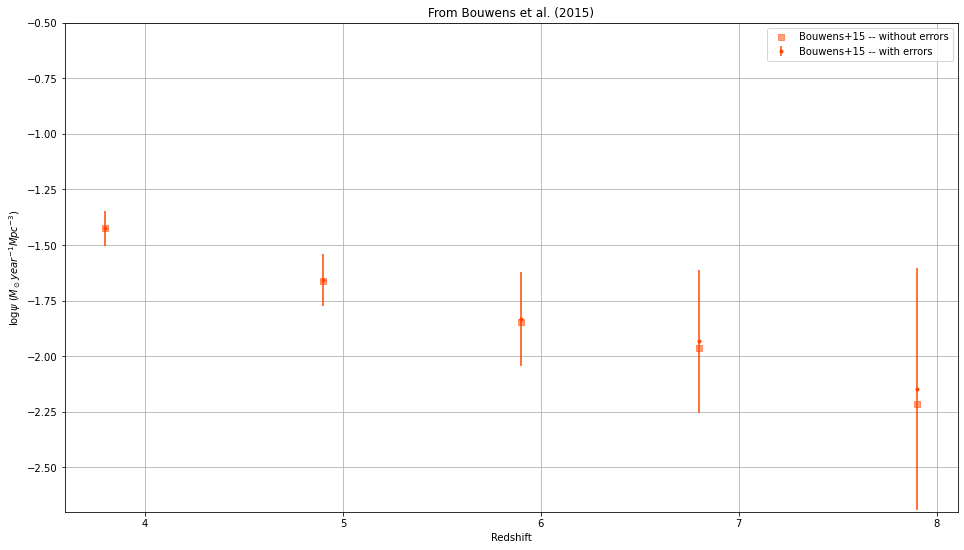

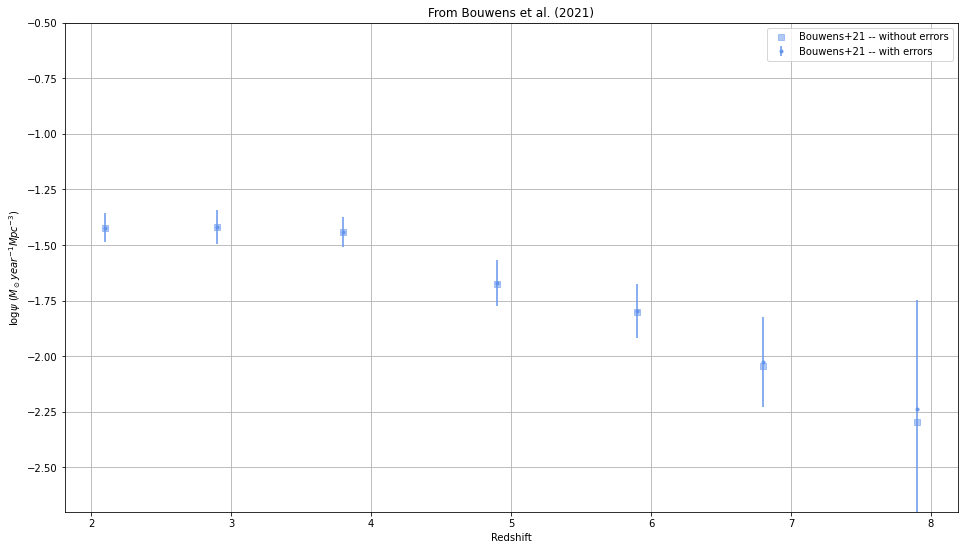

In [5]:
# Computation from Bouwens 2015 and Bouwens 2021
zbou15, sfrd_bou15_wo, sfrd_bou15, sfrd_err_bou15 = np.loadtxt('Bou15_w_wo_cor.dat', usecols=(0,1,2,3), unpack=True)
zbou21, sfrd_bou21_wo, sfrd_bou21, sfrd_err_bou21 = np.loadtxt('Bou21_w_wo_cor.dat', usecols=(0,1,2,3), unpack=True)

log_sfrd_bou15_wo, log_sfrd_bou21_wo = np.log10(sfrd_bou15_wo), np.log10(sfrd_bou21_wo)
log_sfrd_bou15, log_sfrd_err_bou15 = utl.log_err(sfrd_bou15, sfrd_err_bou15)
log_sfrd_bou21, log_sfrd_err_bou21 = utl.log_err(sfrd_bou21, sfrd_err_bou21)

plt.figure(figsize=(16,9))
plt.scatter(zbou15, log_sfrd_bou15_wo, marker='s', c='orangered', label='Bouwens+15 -- without errors', alpha=0.5)
plt.errorbar(zbou15, log_sfrd_bou15, yerr=log_sfrd_err_bou15, fmt='.', label='Bouwens+15 -- with errors', c='orangered')
plt.title('From Bouwens et al. (2015)')
plt.xlabel('Redshift')
plt.ylabel(r'$\log{\psi}$ ($M_\odot year^{-1} Mpc^{-3}$)')
plt.ylim([-2.7, -0.5])
plt.grid()
plt.legend(loc='best')
plt.show()
plt.figure(figsize=(16,9))
plt.scatter(zbou21, log_sfrd_bou21_wo, marker='s', c='cornflowerblue', label='Bouwens+21 -- without errors', alpha=0.5)
plt.errorbar(zbou21, log_sfrd_bou21, yerr=log_sfrd_err_bou21, fmt='.', label='Bouwens+21 -- with errors', c='cornflowerblue')
plt.title('From Bouwens et al. (2021)')
plt.xlabel('Redshift')
plt.ylabel(r'$\log{\psi}$ ($M_\odot year^{-1} Mpc^{-3}$)')
plt.grid()
plt.ylim([-2.7, -0.5])
plt.legend(loc='best')

Note that, the errorbars in SFRDs are pretty large, especially at the higher redshifts. Although, at lower redshifts, the SFRDs computed without assuming errors in the Schechter function parameters matches very well with the ones computed with proper error propagation, this is not the case at the higher redshifts. This is also evident from both of above figures. After redshifts around $z\sim 6$, both of these values diverges. What is going on here?

### Asymmetric errors in the Schechter function parameter $\phi_*$

Could this be due to the fact that errors in the Schechter function parameter $\phi_*$ is highly asymmetric, and while calculating errors above, we have assumed the Gaussian symmetric random normal distribution? To test this hypothesis, we sample an asymmetric Gaussian distribution in $\phi_*$. We do this by taking two Gaussian _symmetric_ distribution (for different positive and negative errors in $\phi_*$) and later merging them --- and finally taking median and $68\%$ as errors in measured SFRD. More details about this function can be found here. Belowe we plot our attempt to include asymmetric errors in $\phi_*$ while propagating errors in SFRD.

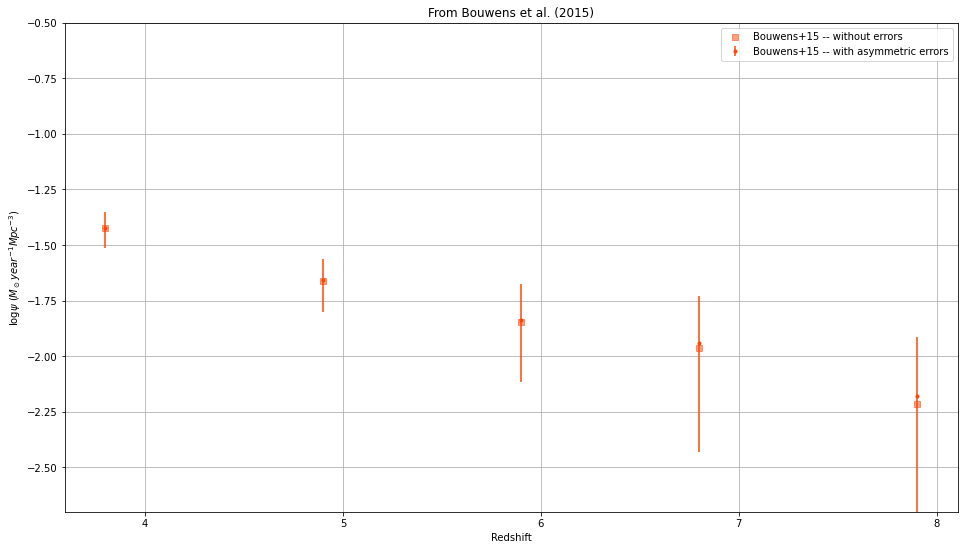

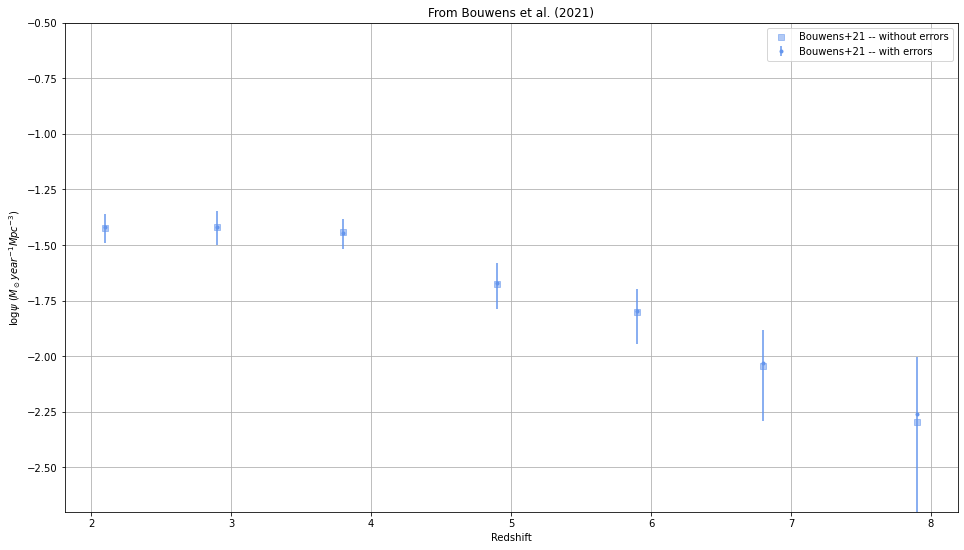

In [6]:
# Computation from Bouwens 2015 and Bouwens 2021
sfrd_asy_bou15, sfrd_asy_perr_bou15, sfrd_asy_nerr_bou15 = np.loadtxt('Bou15_asy.dat', usecols=(1,2,3), unpack=True)
sfrd_asy_bou21, sfrd_asy_perr_bou21, sfrd_asy_nerr_bou21 = np.loadtxt('Bou21_asy.dat', usecols=(1,2,3), unpack=True)

log_sfrd_asy_bou15, log_sfrd_asy_perr_bou15 = utl.log_err(sfrd_asy_bou15, sfrd_asy_perr_bou15)
log_sfrd_asy_bou15, log_sfrd_asy_nerr_bou15 = utl.log_err(sfrd_asy_bou15, sfrd_asy_nerr_bou15)
log_sfrd_asy_bou21, log_sfrd_asy_perr_bou21 = utl.log_err(sfrd_asy_bou21, sfrd_asy_perr_bou21)
log_sfrd_asy_bou21, log_sfrd_asy_nerr_bou21 = utl.log_err(sfrd_asy_bou21, sfrd_asy_nerr_bou21)

plt.figure(figsize=(16,9))
plt.scatter(zbou15, log_sfrd_bou15_wo, marker='s', c='orangered', label='Bouwens+15 -- without errors', alpha=0.5)
plt.errorbar(zbou15, log_sfrd_asy_bou15, yerr=[log_sfrd_asy_perr_bou15, log_sfrd_asy_nerr_bou15], fmt='.', label='Bouwens+15 -- with asymmetric errors', c='orangered')
plt.title('From Bouwens et al. (2015)')
plt.xlabel('Redshift')
plt.ylabel(r'$\log{\psi}$ ($M_\odot year^{-1} Mpc^{-3}$)')
plt.grid()
plt.legend(loc='best')
plt.ylim([-2.7, -0.5])
plt.show()
plt.figure(figsize=(16,9))
plt.scatter(zbou21, log_sfrd_bou21_wo, marker='s', c='cornflowerblue', label='Bouwens+21 -- without errors', alpha=0.5)
plt.errorbar(zbou21, log_sfrd_asy_bou21, yerr=[log_sfrd_asy_perr_bou21, log_sfrd_asy_nerr_bou21], fmt='.', label='Bouwens+21 -- with errors', c='cornflowerblue')
plt.title('From Bouwens et al. (2021)')
plt.xlabel('Redshift')
plt.ylabel(r'$\log{\psi}$ ($M_\odot year^{-1} Mpc^{-3}$)')
plt.grid()
plt.ylim([-2.7, -0.5])
plt.legend(loc='best')

It can be observed from above figures that incorporating asymmetric errorbars in one of the Schechter function parameters does not help much constraining SFRDs, especially at higher redshifts. In addition to this, the errorbars in SFRDs (again, specially at higher redshifts) become highly asymmetric.

### Correlated Schechter function parameters

It has been shown in recent studies (e.g., Bouwens et al. 2015; Bouwens et al. 2021) that the Schechter function parameters are correlated in nature. Hence, we want to see that whether this could have any effect on constraining SFRD. Now, we have been provided with the contours of $68\%$ confidence intervals -- we used [this](https://automeris.io/WebPlotDigitizer/) online tool to extract the data from graphs. Later we determine a covariance matrix from this contours and using `numpy` function `numpy.random.multivariate_normal` to draw correlated samples. We then used these correlated samples to calculate final SFRD, which we have shown below.

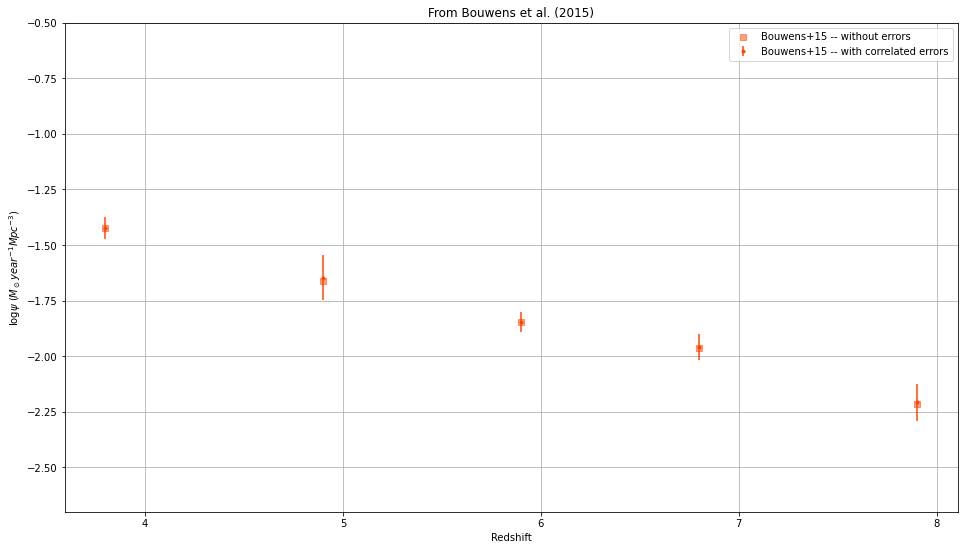

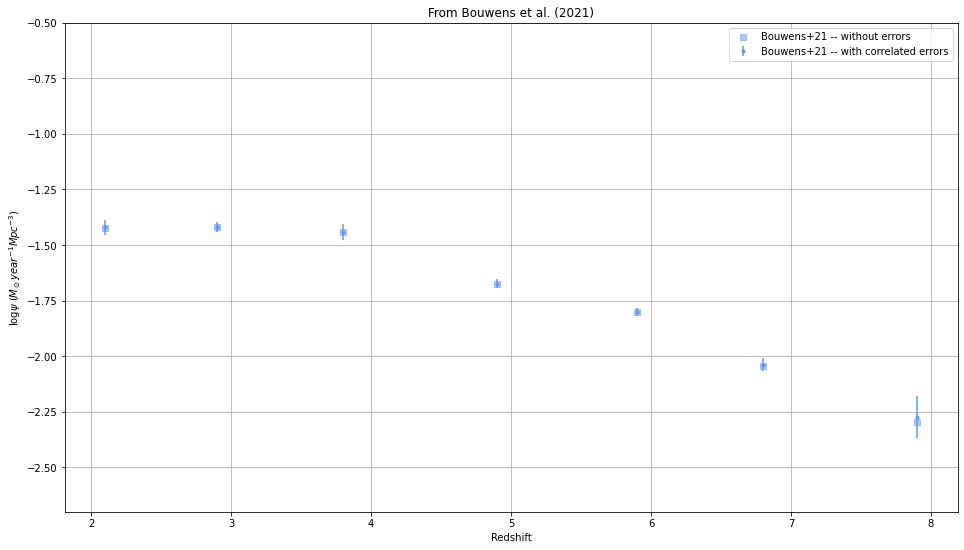

In [7]:
# Computation from Bouwens 2015 and Bouwens 2021
sfrd_cor_bou15, sfrd_cor_err_bou15 = np.loadtxt('Bou15_w_wo_cor.dat', usecols=(4,5), unpack=True)
sfrd_cor_bou21, sfrd_cor_err_bou21 = np.loadtxt('Bou21_w_wo_cor.dat', usecols=(4,5), unpack=True)

log_sfrd_cor_bou15, log_sfrd_cor_err_bou15 = utl.log_err(sfrd_cor_bou15, sfrd_cor_err_bou15)
log_sfrd_cor_bou21, log_sfrd_cor_err_bou21 = utl.log_err(sfrd_cor_bou21, sfrd_cor_err_bou21)

plt.figure(figsize=(16,9))
plt.scatter(zbou15, log_sfrd_bou15_wo, marker='s', c='orangered', label='Bouwens+15 -- without errors', alpha=0.5)
plt.errorbar(zbou15, log_sfrd_cor_bou15, yerr=log_sfrd_cor_err_bou15, fmt='.', label='Bouwens+15 -- with correlated errors', c='orangered')
plt.title('From Bouwens et al. (2015)')
plt.xlabel('Redshift')
plt.ylabel(r'$\log{\psi}$ ($M_\odot year^{-1} Mpc^{-3}$)')
plt.grid()
plt.ylim([-2.7, -0.5])
plt.legend(loc='best')
plt.show()
plt.figure(figsize=(16,9))
plt.scatter(zbou21, log_sfrd_bou21_wo, marker='s', c='cornflowerblue', label='Bouwens+21 -- without errors', alpha=0.5)
plt.errorbar(zbou21, log_sfrd_cor_bou21, yerr=log_sfrd_cor_err_bou21, fmt='.', label='Bouwens+21 -- with correlated errors', c='cornflowerblue')
plt.title('From Bouwens et al. (2021)')
plt.xlabel('Redshift')
plt.ylabel(r'$\log{\psi}$ ($M_\odot year^{-1} Mpc^{-3}$)')
plt.grid()
plt.ylim([-2.7, -0.5])
plt.legend(loc='best')

It can be noted from above figures that the SFRDs are now more tightly constrained than from the previous cases. Plus, except for the highest redshifts, the values of SFRD with and without error propagation match very well.